# **Challenger la grille de score avec un modèle de Machine Learning**  

Nous allons tester l'**Arbre de Décision**, un modèle simple mais efficace. Il est particulièrement intéressant pour le scoring de crédit, car il offre une bonne **interprétabilité** en permettant de visualiser les règles de décision. De plus, il gère **naturellement les valeurs manquantes** et s’adapte aux **relations non linéaires**, ce qui en fait un candidat pertinent pour challenger la grille de score.

In [41]:
import pandas as pd
import numpy as np

# Charger les données
df = pd.read_csv("../data/data_cleaned.csv")

# Afficher les informations avant transformation
df.info()
print(df.head(5).to_string(index=False))

# Appliquer le One-Hot Encoding sur les colonnes catégorielles
df = pd.get_dummies(df, drop_first=True)

# Afficher les informations après encodage
df.info()

# Fonction de downcasting pour optimiser la mémoire
def downcast(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        # Downcast les types entiers
        if np.issubdtype(col_type, np.integer):
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].between(np.iinfo(np.uint8).min, np.iinfo(np.uint8).max).all():
                df[col] = df[col].astype(np.uint8)
            elif df[col].between(np.iinfo(np.int8).min, np.iinfo(np.int8).max).all():
                df[col] = df[col].astype(np.int8)
            elif df[col].between(np.iinfo(np.uint16).min, np.iinfo(np.uint16).max).all():
                df[col] = df[col].astype(np.uint16)
            elif df[col].between(np.iinfo(np.int16).min, np.iinfo(np.int16).max).all():
                df[col] = df[col].astype(np.int16)
            elif df[col].between(np.iinfo(np.uint32).min, np.iinfo(np.uint32).max).all():
                df[col] = df[col].astype(np.uint32)
            elif df[col].between(np.iinfo(np.int32).min, np.iinfo(np.int32).max).all():
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)

        # Downcast les types flottants
        elif np.issubdtype(col_type, np.floating):
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].between(np.finfo(np.float16).min, np.finfo(np.float16).max).all():
                df[col] = df[col].astype(np.float16)
            elif df[col].between(np.finfo(np.float32).min, np.finfo(np.float32).max).all():
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

        # Convertir les objets en catégories (sauf dates)
        elif df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
            except:
                df[col] = df[col].astype('category')

    return df  

# Appliquer le downcasting
df = downcast(df)

# Vérification après downcasting
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252136 entries, 0 to 252135
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  252136 non-null  int64  
 1   GOOD_PAYER                  252136 non-null  int64  
 2   CODE_GENDER                 252136 non-null  object 
 3   FLAG_OWN_CAR                252136 non-null  object 
 4   FLAG_OWN_REALTY             252136 non-null  object 
 5   CNT_CHILDREN                252136 non-null  int64  
 6   AMT_INCOME_TOTAL            252136 non-null  float64
 7   AMT_CREDIT                  252136 non-null  float64
 8   NAME_INCOME_TYPE            252136 non-null  object 
 9   NAME_CONTRACT_TYPE          252136 non-null  object 
 10  NAME_EDUCATION_TYPE         252136 non-null  object 
 11  NAME_FAMILY_STATUS          252136 non-null  object 
 12  NAME_HOUSING_TYPE           252136 non-null  object 
 13  DAYS_BIRTH    

## 
- option stratify=y garantit que les proportions des classes dans chaque sous-ensemble (train, validation, test) sont identiques à celles de l'ensemble initial.


In [42]:
from sklearn.model_selection import train_test_split

# Définir les features et la cible
X = df.drop(columns=['GOOD_PAYER'])  
y = df['GOOD_PAYER']  

# Split des données : 80% Train, 20% Test + stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Fonction objective pour Optuna
def objective(trial):
    # Hyperparamètres à tester
    max_depth = trial.suggest_int('max_depth', 3, 13, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # Initialisation de l'arbre de décision avec les hyperparamètres suggérés
    model = DecisionTreeClassifier(max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf, 
                                   criterion=criterion, 
                                   random_state=42)
    
    # Cross-validation pour évaluer l'arbre de décision
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score

# Création de l'étude d'optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# Meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres trouvés : ", study.best_params)
print("Meilleur F1-score : ", study.best_value)


[I 2025-02-01 21:00:16,933] A new study created in memory with name: no-name-323130b8-92ca-43ca-8a78-9efd9a0fb6b6
[I 2025-02-01 21:00:22,809] Trial 0 finished with value: 0.9547255551200612 and parameters: {'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.9547255551200612.
[I 2025-02-01 21:00:32,939] Trial 1 finished with value: 0.9542392505702182 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9547255551200612.


Meilleurs hyperparamètres trouvés :  {'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'gini'}
Meilleur F1-score :  0.9547255551200612


In [46]:
# Entraîner le modèle final avec les meilleurs hyperparamètres et évaluer sur le jeu de test
best_model = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion='entropy',
    random_state=42)
best_model.fit(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print("Score sur le jeu de test : ", test_score)


Score sur le jeu de test :  0.9134012850003966


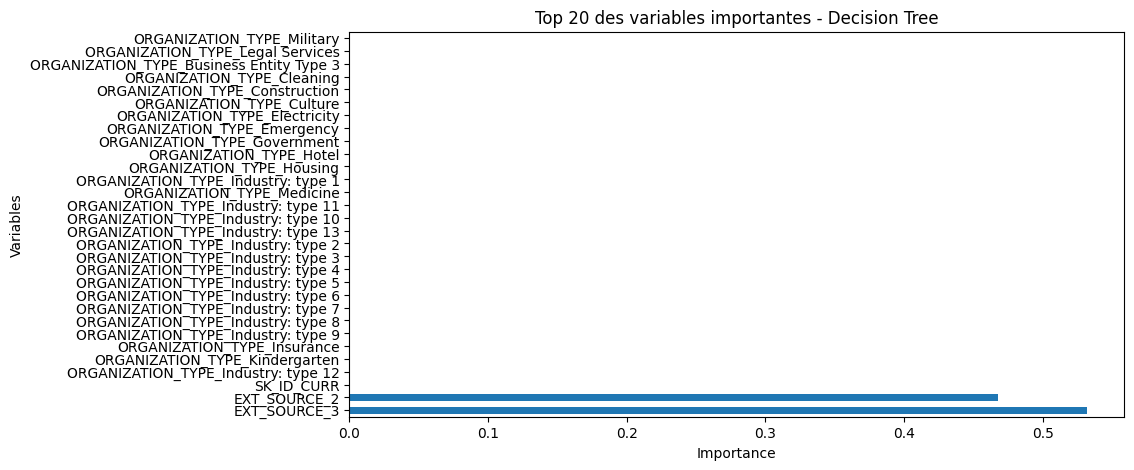

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtenir les importances des caractéristiques
importances = best_model.feature_importances_

# Créer une série pandas avec les importances et les noms des colonnes
importances_series = pd.Series(importances, index=X_train.columns)

# Sélectionner les 20 premières importances triées
top_20_importances = importances_series.sort_values(ascending=False).head(30)

# Affichage horizontal des 20 premières importances
top_20_importances.plot(kind='barh', figsize=(10,5))
plt.title("Top 20 des variables importantes - Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.show()
